# CHART Analysis Tutorial

The CHART data taking packages produces two types of file- a data file, and a metadata file. The data file will have a ".dat" extension, and the metadata has a ".metadata.npz". Each observation should have an associated data and metadata file. The metadata has information about the data, such as the frequencies and times of the observation, and the data contains the observation.

In order to see the 21-cm signal from the galaxy, some data processings steps are needed. First, we do some simple calibration and plotting steps to look at our data.

## Data Processing and Plotting

First, we need to import the python packages used for the analysis. If you are using the provided Raspberry Pi image, these should already be installed. If you are not, you will need to install them with a package manager such as pip or conda. Run the cell below to import the packages.

In [1]:
%matplotlib inline
import numpy
import numpy as np
import matplotlib.pyplot as plt
import chart
from astropy import units as u
from astropy.coordinates import SpectralCoord, EarthLocation, SkyCoord, AltAz, ICRS
from astropy.time import Time
import pandas as pd
import math
import scipy.stats
import scipy.stats as stats
from scipy.optimize import curve_fit
import ipywidgets as widgets
from ipywidgets import *
from ipywidgets import interact, FloatSlider, Dropdown
from scipy.stats import chi2

The cell below imports a few constants and useful functions. These constants and functions will be used in later steps of the code. Run the cell below to import the functions.

In [2]:
# A couple constants and useful functions for later.
f0 = 1.420405751768  # GHz
speed_of_light = 299792458  # m/s
c = 3e8 * (u.meter/u.second)

def plot_f0(lims=[30, 40], xval=f0):
    plt.plot([xval, xval], lims, '--k', lw=0.5)
def f2v(freq):
    return -(np.array(freq)-f0) * speed_of_light / np.array(freq)
def doppler(shifted,rest):
    v = (c*(shifted-rest*u.GHz)/(shifted))
    return v 
def LSR_shift(longitude, latitude, elevation, time, altitude, azimuth):
    """
    Identifies the exact postion at which the observations were taken and corrects for the Local Standard of Rest. 
    Along with this it also converts location, altitude, and azimuth to galactic coordinates.
    
    :param latitude: latitude in degrees
    :param longitude: longitude in degrees
    :param elevation: elevation in meters
    :param time: observation time in UTC format string
    :param altitude: altitude in degrees
    :param azimuth: azimuth in degrees
    """
    
    loc = EarthLocation(lat=latitude*u.deg, lon=longitude*u.deg, height=elevation*u.m)
    altaz = AltAz(obstime=Time(time), location=loc, alt=altitude*u.deg, az=azimuth*u.deg)
    skycoord = SkyCoord(altaz.transform_to(ICRS))
    location = EarthLocation.from_geodetic(longitude, latitude, elevation*u.m) #Lon, Lat, elevation
    location = location.get_itrs(obstime=Time(time)) #To ITRS frame, makes Earth stationary with Sun 
    pointing_45deg = SkyCoord(altaz.transform_to(ICRS)) #Center of CHART pointing
    frequency = SpectralCoord(1.420405751768e9 * u.Hz, observer=location, target=pointing_45deg) #Shift expected from just local motion
    f0_shifted = frequency.with_observer_stationary_relative_to('lsrk') #correct for kinematic local standard of rest
    f0_shifted = f0_shifted.to(u.GHz)
    v = doppler(f0_shifted,f0)
    v_adjustment = v.to(u.km/u.second)
    return v_adjustment, skycoord.galactic

def find_array_with_number(freqs, pointing, number):
    for k_index, k in enumerate(freqs[pointing]):
        if numpy.any((k[:-1] <= number) & (number <= k[1:])):
            return k_index, k
    return None, None

def average_overlapping(x1, y1, x2, y2):
    """
    Averages the y values where the x values are shared between two arrays and keeps y values for x values that are not shared.
    
    :param x1: First x array
    :param y1: First y array
    :param x2: Second x array
    :param y2: Second y array
    :return: Tuple of combined x values and averaged/kept y values
    """
    # Find the unique x values in both arrays
    unique_x = np.union1d(x1, x2)
    
    # Create an array to store the averaged/kept y values
    avg_y = np.zeros_like(unique_x)
    
    # Iterate over the unique x values
    for i in range(len(unique_x)):
        # Find the indices of the current x value in the two x arrays
        ind1 = np.where(x1 == unique_x[i])[0]
        ind2 = np.where(x2 == unique_x[i])[0]
        
        # If the current x value is in both arrays
        if len(ind1) > 0 and len(ind2) > 0:
            # Compute the average of the two corresponding y values
            avg_y[i] = (y1[ind1[0]] + y2[ind2[0]]) / 2
        # If the current x value is only in the first array
        elif len(ind1) > 0:
            # Keep the corresponding y value from the first array
            avg_y[i] = y1[ind1[0]]
        # If the current x value is only in the second array
        elif len(ind2) > 0:
            # Keep the corresponding y value from the second array
            avg_y[i] = y2[ind2[0]]
    
    return unique_x, avg_y


def interactive_plot(unique_x):
    """
    Creates a plot that can be modified with sliders.
    
    param unique_x: x values of overlapping CHART data
    """
    x = unique_x
    e = 2.71828  
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    a = b = c = [1]*4

    lines = [ax.plot(x, (a[i]*(e ** -(((x-b[i])**2) / (2*(c[i]**2))))))[0] for i in range(4)]
    lines.append(ax.plot(x, sum([a[i]*(e ** -(((x-b[i])**2) / (2*(c[i]**2)))) for i in range(4)]))[0])

    sliders = [FloatSlider(min=-100, max=100, step=1, value=1) for _ in range(12)]
    colors = ['black']*4 + ['red']
    color_dropdowns = [Dropdown(options=['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'], value=colors[i]) for i in range(5)]

    def update(a1=1, b1=1, c1=1, a2=1, b2=1, c2=1, a3=1, b3=1, c3=1, a4=1, b4=1, c4=1,
               color1='black', color2='black', color3='black', color4='black', color5='red'):
        a = [a1,a2,a3,a4]
        b = [b1,b2,b3,b4]
        c = [c1,c2,c3,c4]
        for i in range(4):
            lines[i].set_ydata((a[i]*(e ** -(((x-b[i])**2) / (2*(c[i]**2))))))
        lines[4].set_ydata(sum([a[i]*(e ** -(((x-b[i])**2) / (2*(c[i]**2)))) for i in range(4)]))
        for i in range(5):
            lines[i].set_color([color1,color2,color3,color4,color5][i])
        fig.canvas.draw_idle()

    interact(update,
             a1=sliders[0], b1=sliders[1], c1=sliders[2],
             a2=sliders[3], b2=sliders[4], c2=sliders[5],
             a3=sliders[6], b3=sliders[7], c3=sliders[8],
             a4=sliders[9], b4=sliders[10], c4=sliders[11],
             color1=color_dropdowns[0], color2=color_dropdowns[1],
             color3=color_dropdowns[2], color4=color_dropdowns[3],
             color5=color_dropdowns[4])
     
    return ax

    
def goodness_of_fit(unique_x, combined_gauss, avg_y):
    """Performs a chi-squared goodness of fit test between the CHART data and the user created combined Gaussian curve.
    
    param unique_x: x values of overlapping CHART data
    param combined_gauss: y values of combined Gaissian curve
    param avg: y values of overlapping CHART data
    """
    x_gauss = np.array(unique_x)
    y_gauss = np.array(combined_gauss)
    x_data = np.array(unique_x) 
    y_data = np.array(avg_y) 

    gauss = np.concatenate((x_gauss.reshape(-1,1), y_gauss.reshape(-1,1)), axis=1)
    data = np.concatenate((x_data.reshape(-1,1), y_data.reshape(-1,1)), axis=1)


    mask = (gauss[:,0] >= -100) & (gauss[:,0] <= 100)
    gauss_masked = gauss[mask]
    data_masked = data[mask]

    chi_squared_statistic_x = np.sum((gauss_masked[:,0] - data_masked[:,0])**2 / data_masked[:,0])
    chi_squared_statistic_y = np.sum((y_gauss - y_data)**2 / y_data)

    p_value_x = chi2.sf(chi_squared_statistic_x, len(gauss_masked[:,0]) - 1)
    p_value_y = chi2.sf(chi_squared_statistic_y, len(y_gauss) - 1)

    #print("Chi-squared Statistic for x: ", chi_squared_statistic_x)
    #print("P-value for x: ", p_value_x)
    #print("Chi-squared Statistic for y: ", chi_squared_statistic_y)
    print("P-value for y: ", p_value_y)

Now, we read in our data. Each observation you took should have produced a directory with a time and data. The 'data_dir' parameter indicates the larger file tree where your observations are location (you can find this in the linux terminal by typing 'pwd'. Here, ours is called '/data/'. The 'paths' parameter is a list of your observations within the '/data/' (or whatever yours is called) directory. There may be more or less than three depending on how many observations you took, you can simply add more to the list if you have more than three. 

Replace the file directory and the file names into the first two lines below, replacing the data_dir and paths variables. Each path represents what we call a 'pointing'. A pointing is an observation made in a specific direction that can be defined by its altitude and azimuth, its celestial coordinates, or its galactic coordinates.   

Now, run the cell below. It will print out some information about each observation from your metadata, such as the data, time, and center frequency, as well as a few other parameters.

In [3]:
data_dir = 'test_data/'
paths = ['abeardsley_Winona-HS-Park_2022.10.08_1_6:12_pm','abeardsley_Winona-HS-Park_2022.10.8_2_6:25_pm',
         'abeardsley_Winona-HS-Park_2022.10.8_3_6:30_pm']

ntrials = len(paths)

data = []
mdata = []
bps = []  # bandpasses

for i in range(ntrials):
    d, m = chart.analysis.read_run(directory=data_dir + paths[i])
    d = np.array(d)
    data.append(d)
    mdata.append(m)
    # Rough estimate for bandpass
    nchans = m[0]['vector_length']
    levels = np.median(d[:, :, nchans // 4:(-nchans // 4)], axis=(1, 2))
    rescaled = d / levels.reshape(-1, 1, 1)
    bp = np.median(rescaled, axis=(0, 1))
    bps.append(bp)

for i in range(ntrials):
    print('Trial: '+str(i))
    chart.analysis.print_meta(m[i])

Trial: 0
date :	 2022-10-08
start_time :	 1665271803.061299
end_time :	 1665271814.9317102
samp_rate :	 2000000.0
frequency :	 1410000000.0
vector_length :	 1024
int_length :	 976
data_file :	 /home/pi/data/abeardsley_Winona-HS-Park_2022.10.8_3_6:30_pm/2022-10-08_18-30-03.562153.dat
metadata_file :	 /home/pi/data/abeardsley_Winona-HS-Park_2022.10.8_3_6:30_pm/2022-10-08_18-30-03.562153.metadata.npz
Number of time integrations:	20
dtype :	 [<class 'numpy.float32'>]
Trial: 1
date :	 2022-10-08
start_time :	 1665271803.061299
end_time :	 1665271826.6499507
samp_rate :	 2000000.0
frequency :	 1411000000.0
vector_length :	 1024
int_length :	 976
data_file :	 /home/pi/data/abeardsley_Winona-HS-Park_2022.10.8_3_6:30_pm/2022-10-08_18-30-15.541138.dat
metadata_file :	 /home/pi/data/abeardsley_Winona-HS-Park_2022.10.8_3_6:30_pm/2022-10-08_18-30-15.541138.metadata.npz
Number of time integrations:	20
dtype :	 [<class 'numpy.float32'>]
Trial: 2
date :	 2022-10-08
start_time :	 1665271803.061299
end_

The next three cells plot the raw CHART data for each pointing. The x-axis represents the recorded frequencies in Gigahertz and the y-axis shows the signal strength in decibels (dB) for each frequency. Each color represnts a different 'tuning' in the data. The software defined radio used for taking data has a limited frequency range, and can only digitize 2 MHz worth of data at a time. In order to scan a larger frequency range, the SDR must do it in steps, or 'tunings'. It will be difficult to see anything in the data in these plots, as a few calibration steps are needed. The vertical blue line indicates the rest frequency of neutral hydrogen.

Text(0.5, 0, 'Frequency [GHz]')

<Figure size 432x288 with 0 Axes>

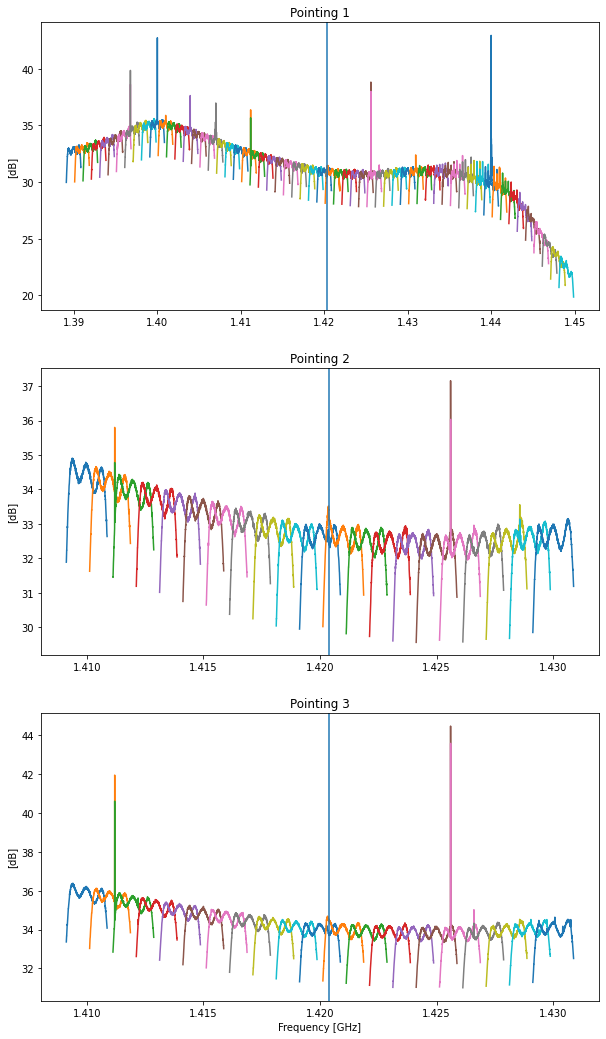

In [4]:
ntrials = len(data)
spectra = [[] for _ in range(ntrials)]
freqs = [[] for _ in range(ntrials)]
nremove = nchans // 16

for pointing in range(ntrials):
    for d, m in zip(data[pointing], mdata[pointing]):
        spectrum = np.mean(d, axis=0) 
        spectrum = 10*np.log10(spectrum)
        spectrum = spectrum[nremove:-nremove]
        frequencies = ((np.arange(m['vector_length']) - m['vector_length'] / 2)
                           * m['samp_rate'] / m['vector_length'] + m['frequency'])
        frequencies = 1e-9 * frequencies[nremove:-nremove]
        spectra[pointing].append(spectrum)
        freqs[pointing].append(frequencies)

    for k in range(len(spectra[pointing]) - 1):
        spec1 = spectra[pointing][k]
        spec2 = spectra[pointing][k + 1]
        freq1 = freqs[pointing][k]
        freq2 = freqs[pointing][k + 1]
        ncommon = np.sum([1 if f in freq2 else 0 for f in freq1])
        spec2 += np.median(spec1[-ncommon:]) - np.median(spec2[:ncommon])
        spectra[pointing][k + 1] = spec2

plt.figure()
fig, axs = plt.subplots(ntrials, 1, figsize=(10,18))
for pointing in range(ntrials):
    for f, s in zip(freqs[pointing], spectra[pointing]):
        axs[pointing].plot(f, s)
    axs[pointing].set_title(f'Pointing {pointing+1}')
    axs[pointing].set_ylabel('[dB]')
    axs[pointing].axvline(1.4204)
#plt.xlim(1.42,1.421)   
plt.xlabel('Frequency [GHz]')

Now, we will correct for the bandpass of the software defined radio.
After the data is collected from the antenna it passes through a bandpass filter located in our SDR. A bandpass filter is used to isolate a specific frequency range of interest from the broader spectrum of electromagnetic radiation received by the telescope. This filter allows signals within the desired bandpass to pass through with little interference while blocking signals outside that range. However, this bandpass filter has a frequency-dependent response that imparts a shape onto our data. This is the repeating stucture seen in each tuning above. The next cell will calibrate for this bandpass, removing that shape from the data. There still may be some overall shape across the whole frequency range caused by frequency dependence of the electronics, but we don't worry about that as our 21-cm signal is in a fairly narrow range. If the 21-cm signal is visible in your data, you should now be able to see it near the line that indicates the rest frequency after running the cell below! 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Frequency [GHz]')

<Figure size 432x288 with 0 Axes>

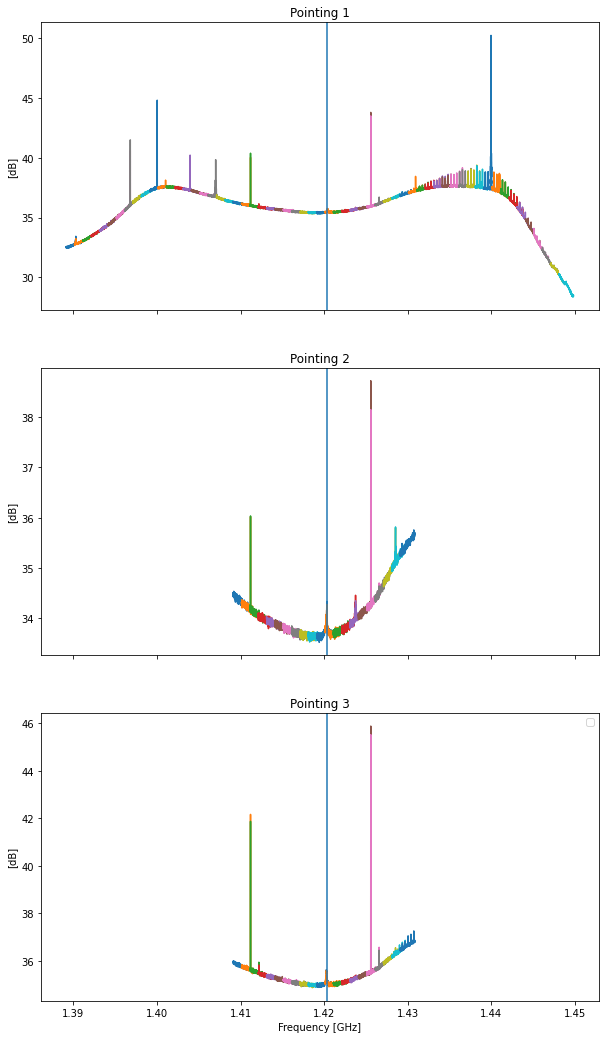

In [5]:
ntrials = len(data)
spectra = [[] for _ in range(ntrials)]
freqs = [[] for _ in range(ntrials)]
nremove = nchans // 16

for pointing in range(ntrials):
    for d, m in zip(data[pointing], mdata[pointing]):
        spectrum = np.mean(d, axis=0) /bps[0]
        spectrum = 10*np.log10(spectrum)
        spectrum = spectrum[nremove:-nremove]
        frequencies = ((np.arange(m['vector_length']) - m['vector_length'] / 2)
                           * m['samp_rate'] / m['vector_length'] + m['frequency'])
        frequencies = 1e-9 * frequencies[nremove:-nremove]
        spectra[pointing].append(spectrum)
        freqs[pointing].append(frequencies)

    for k in range(len(spectra[pointing]) - 1):
        spec1 = spectra[pointing][k]
        spec2 = spectra[pointing][k + 1]
        freq1 = freqs[pointing][k]
        freq2 = freqs[pointing][k + 1]
        ncommon = np.sum([1 if f in freq2 else 0 for f in freq1])
        spec2 += np.median(spec1[-ncommon:]) - np.median(spec2[:ncommon])
        spectra[pointing][k + 1] = spec2
        
plt.figure()
fig, axs = plt.subplots(ntrials, 1, sharex=True, figsize=(10,18))
for pointing in range(ntrials):
    for f, s in zip(freqs[pointing], spectra[pointing]):
        axs[pointing].plot(f, s)
    axs[pointing].set_title(f'Pointing {pointing+1}')
    axs[pointing].set_ylabel('[dB]')
    axs[pointing].axvline(1.4204)
#plt.xlim(1.42,1.421)   
plt.legend()
plt.xlabel('Frequency [GHz]')